In [47]:
pip install medmnist

Note: you may need to restart the kernel to use updated packages.


In [48]:
import medmnist
from medmnist import INFO
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

# Load the dataset
data_flag = 'pathmnist'
download = True

# Get dataset information
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Define transformations for data augmentation
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load the dataset
train_dataset = DataClass(split='train', transform=data_transform, download=download)
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)

val_dataset = DataClass(split='val', transform=data_transform, download=download)
val_loader = DataLoader(dataset=val_dataset, batch_size=256, shuffle=False)

# Define the SimCLR model
class SimCLR(nn.Module):
    def __init__(self, base_model, out_dim):
        super(SimCLR, self).__init__()
        self.encoder = self.get_resnet(base_model)
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def get_resnet(self, base_model):
        model = models.__dict__[base_model](pretrained=False)
        model = nn.Sequential(*list(model.children())[:-1])
        return model

    def forward(self, x):
        h = self.encoder(x)
        h = h.squeeze()
        z = self.projector(h)
        return h, z

model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Define the NT-Xent Loss function
class NT_XentLoss(nn.Module):
    def __init__(self, temperature):
        super(NT_XentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        N = 2 * batch_size
        z = torch.cat((z_i, z_j), dim=0)
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        
        mask = self.mask_correlated_samples(batch_size)
        
        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)

        positives = torch.cat([sim_i_j, sim_j_i], dim=0)
        negatives = sim[mask].reshape(N, -1)

        labels = torch.zeros(N).to(positives.device).long()
        logits = torch.cat((positives.unsqueeze(1), negatives), dim=1)
        loss = self.criterion(logits, labels)
        #print(labels)
        return loss / N

criterion = NT_XentLoss(temperature=0.5).cuda()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)

# Training loop
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()

        # Forward pass
        h, z = model(data)
        # Split z into two parts for positive pairs
        z_i, z_j = torch.chunk(z, 2, dim=0)
        loss = criterion(z_i, z_j)

        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    return total_loss / len(train_loader)

# Training the model
num_epochs = 30
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, epoch)
    print(f'Epoch {epoch}, Train Loss: {train_loss}')

# Save features for evaluation
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h, _ = model(data)
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

save_features(model, val_loader, 'pathmnist_features.npz')


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0, Batch 0, Loss: 5.556711196899414
Epoch 0, Batch 10, Loss: 5.546394348144531
Epoch 0, Batch 20, Loss: 5.550464630126953
Epoch 0, Batch 30, Loss: 5.54328727722168
Epoch 0, Batch 40, Loss: 5.539363861083984
Epoch 0, Batch 50, Loss: 5.534570693969727
Epoch 0, Batch 60, Loss: 5.538779258728027
Epoch 0, Batch 70, Loss: 5.5477118492126465
Epoch 0, Batch 80, Loss: 5.54147481918335
Epoch 0, Batch 90, Loss: 5.53902006149292
Epoch 0, Batch 100, Loss: 5.538700103759766
Epoch 0, Batch 110, Loss: 5.539423942565918
Epoch 0, Batch 120, Loss: 5.54659366607666
Epoch 0, Batch 130, Loss: 5.543280601501465
Epoch 0, Batch 140, Loss: 5.542616844177246
Epoch 0, Batch 150, Loss: 5.543473720550537
Epoch 0, Batch 160, Loss: 5.538918495178223
Epoch 0, Batch 170, Loss: 5.543483734130859
Epoch 0, Batch 180, Loss: 5.541567325592041
Epoch 0, Batch 190, Loss: 5.5431013107299805
Epoch 0, Batch 200, Loss: 5.54224157333374
Epoch 0, Batch 210, Loss: 5.54278564453125
Epoch 0, Batch 220, Loss: 5.539090156555176
Epo

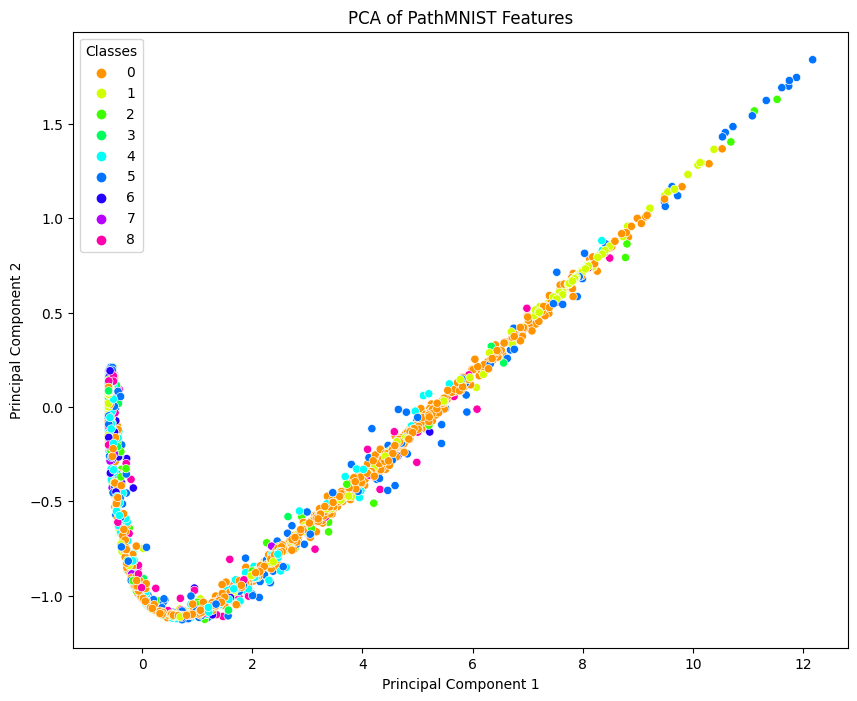

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

# Load features
data = np.load('pathmnist_features.npz')
features = data['features']
labels = data['labels']

# Perform PCA to reduce dimensions to 2
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# Ensure labels are 1D
labels = labels.squeeze()

# Create a DataFrame with the PCA results and labels
df = pd.DataFrame({
    'PC1': features_2d[:, 0],
    'PC2': features_2d[:, 1],
    'Label': labels
})

# Visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Label', legend='full', palette=palette)
plt.title('PCA of PathMNIST Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Classes')
plt.show()


In [50]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load features
data = np.load('pathmnist_features.npz')
features = data['features']
labels = data['labels']

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train logistic regression classifier
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)

# Predict on validation set
y_pred = classifier.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation Accuracy: 0.4428


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [51]:
# Save the model parameters
torch.save(model.state_dict(), 'simclr_model.pth')


In [57]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode


# Extract 1% of training data for fine-tuning
num_samples = len(train_dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)
fine_tune_size = int(num_samples * 0.01)
fine_tune_indices = indices[:fine_tune_size]

fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=train_dataset, batch_size=256, sampler=fine_tune_sampler)

# Define a simple classifier for fine-tuning
class FineTuneModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = base_model.encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        h = self.encoder(x).squeeze()
        logits = self.classifier(h)
        return logits
# Convert numpy array to list for getting unique labels
num_classes = 9  #len(set(train_dataset.labels.tolist()))
fine_tune_model = FineTuneModel(model, num_classes).cuda()

# Define the loss function and optimizer for fine-tuning
criterion_fine_tune = nn.CrossEntropyLoss()
optimizer_fine_tune = optim.Adam(fine_tune_model.parameters(), lr=1e-4, weight_decay=1e-6)
# Fine-tuning loop
def fine_tune(model, fine_tune_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()  # Ensure target is 1D
        optimizer.zero_grad()

        # Forward pass
        logits = model(data)
        loss = criterion(logits, target)

        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    return total_loss / len(fine_tune_loader)

# Fine-tune the model
fine_tune_epochs = 50
for epoch in range(fine_tune_epochs):
    fine_tune_loss = fine_tune(fine_tune_model, fine_tune_loader, criterion_fine_tune, optimizer_fine_tune, epoch)
    print(f'Fine-tune Epoch {epoch}, Train Loss: {fine_tune_loss}')



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fine-tune Epoch 0, Batch 0, Loss: 2.196916103363037
Fine-tune Epoch 0, Train Loss: 2.1824471950531006
Fine-tune Epoch 1, Batch 0, Loss: 2.153062343597412
Fine-tune Epoch 1, Train Loss: 2.1255685091018677
Fine-tune Epoch 2, Batch 0, Loss: 2.0714468955993652
Fine-tune Epoch 2, Train Loss: 2.042303591966629
Fine-tune Epoch 3, Batch 0, Loss: 1.9344948530197144
Fine-tune Epoch 3, Train Loss: 1.9635265469551086
Fine-tune Epoch 4, Batch 0, Loss: 1.9258521795272827
Fine-tune Epoch 4, Train Loss: 1.878529965877533
Fine-tune Epoch 5, Batch 0, Loss: 1.8856984376907349
Fine-tune Epoch 5, Train Loss: 1.8354843854904175
Fine-tune Epoch 6, Batch 0, Loss: 1.7598676681518555
Fine-tune Epoch 6, Train Loss: 1.8078431487083435
Fine-tune Epoch 7, Batch 0, Loss: 1.7312442064285278
Fine-tune Epoch 7, Train Loss: 1.7530984580516815
Fine-tune Epoch 8, Batch 0, Loss: 1.7060558795928955
Fine-tune Epoch 8, Train Loss: 1.7002263367176056
Fine-tune Epoch 9, Batch 0, Loss: 1.6613340377807617
Fine-tune Epoch 9, Train

In [58]:
def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h = model(data)  # Only get the output from the classifier
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

# Save features from the fine-tuned model for evaluation
save_features(fine_tune_model, val_loader, 'pathmnist_features_fine_tuned.npz')

# Load features
data_fine_tuned = np.load('pathmnist_features_fine_tuned.npz')
features_fine_tuned = data_fine_tuned['features']
labels_fine_tuned = data_fine_tuned['labels']

# Split data into training and testing sets
X_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)

# Standardize the features
scaler_fine_tuned = StandardScaler()
X_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)
X_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)

# Train logistic regression classifier
classifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)
classifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)

# Predict on validation set
y_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)

# Calculate accuracy
accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)
print(f'Fine-tuned Validation Accuracy: {accuracy_fine_tuned:.4f}')

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fine-tuned Validation Accuracy: 0.6417


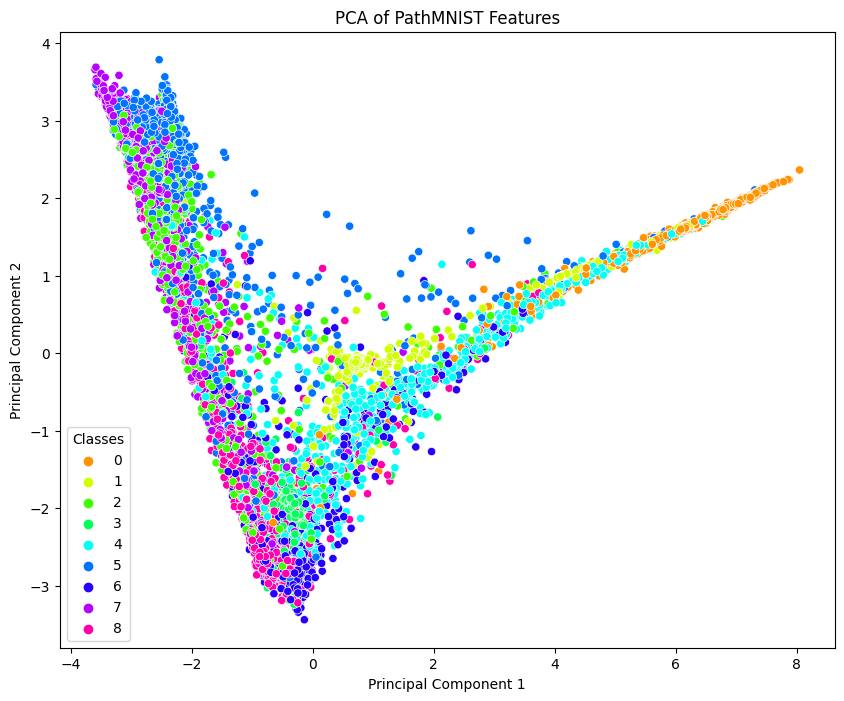

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

# Load features
data = np.load('pathmnist_features_fine_tuned.npz')
features = data['features']
labels = data['labels']

# Perform PCA to reduce dimensions to 2
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# Ensure labels are 1D
labels = labels.squeeze()

# Create a DataFrame with the PCA results and labels
df = pd.DataFrame({
    'PC1': features_2d[:, 0],
    'PC2': features_2d[:, 1],
    'Label': labels
})

# Visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Label', legend='full', palette=palette)
plt.title('PCA of PathMNIST Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Classes')
plt.show()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fine-tune Epoch 0, Batch 0, Loss: 2.201329469680786
Fine-tune Epoch 0, Batch 10, Loss: 2.004732370376587
Fine-tune Epoch 0, Batch 20, Loss: 1.8577592372894287
Fine-tune Epoch 0, Batch 30, Loss: 1.693566083908081
Fine-tune Epoch 0, Train Loss: 1.9094971617062886
Fine-tune Epoch 1, Batch 0, Loss: 1.6419657468795776
Fine-tune Epoch 1, Batch 10, Loss: 1.654565691947937
Fine-tune Epoch 1, Batch 20, Loss: 1.5545574426651
Fine-tune Epoch 1, Batch 30, Loss: 1.484206199645996
Fine-tune Epoch 1, Train Loss: 1.5549923380215962
Fine-tune Epoch 2, Batch 0, Loss: 1.3385682106018066
Fine-tune Epoch 2, Batch 10, Loss: 1.3172816038131714
Fine-tune Epoch 2, Batch 20, Loss: 1.2739031314849854
Fine-tune Epoch 2, Batch 30, Loss: 1.27981436252594
Fine-tune Epoch 2, Train Loss: 1.3066628376642864
Fine-tune Epoch 3, Batch 0, Loss: 1.2553223371505737
Fine-tune Epoch 3, Batch 10, Loss: 1.1471803188323975
Fine-tune Epoch 3, Batch 20, Loss: 1.1511552333831787
Fine-tune Epoch 3, Batch 30, Loss: 0.9973541498184204


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fine-tuned Validation Accuracy: 0.7996


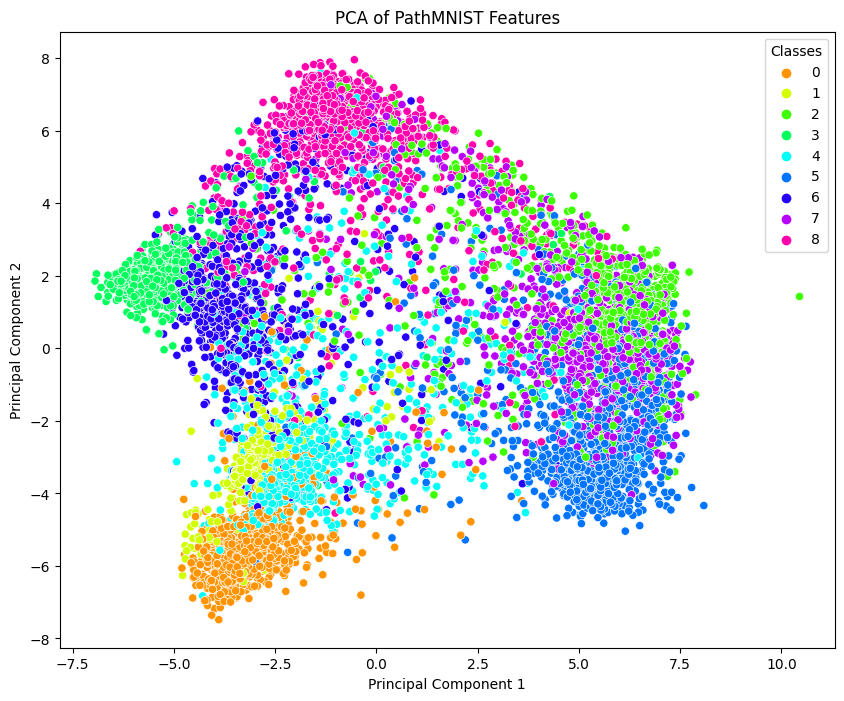

In [60]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode


# Extract 1% of training data for fine-tuning
num_samples = len(train_dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)
fine_tune_size = int(num_samples * 0.1)
fine_tune_indices = indices[:fine_tune_size]

fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=train_dataset, batch_size=256, sampler=fine_tune_sampler)

# Define a simple classifier for fine-tuning
class FineTuneModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = base_model.encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        h = self.encoder(x).squeeze()
        logits = self.classifier(h)
        return logits
# Convert numpy array to list for getting unique labels
num_classes = 9  #len(set(train_dataset.labels.tolist()))
fine_tune_model = FineTuneModel(model, num_classes).cuda()

# Define the loss function and optimizer for fine-tuning
criterion_fine_tune = nn.CrossEntropyLoss()
optimizer_fine_tune = optim.Adam(fine_tune_model.parameters(), lr=1e-4, weight_decay=1e-6)
# Fine-tuning loop
def fine_tune(model, fine_tune_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()  # Ensure target is 1D
        optimizer.zero_grad()

        # Forward pass
        logits = model(data)
        loss = criterion(logits, target)

        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    return total_loss / len(fine_tune_loader)

# Fine-tune the model
fine_tune_epochs = 50
for epoch in range(fine_tune_epochs):
    fine_tune_loss = fine_tune(fine_tune_model, fine_tune_loader, criterion_fine_tune, optimizer_fine_tune, epoch)
    print(f'Fine-tune Epoch {epoch}, Train Loss: {fine_tune_loss}')

def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h = model(data)  # Only get the output from the classifier
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

# Save features from the fine-tuned model for evaluation
save_features(fine_tune_model, val_loader, 'pathmnist_features_fine_tuned.npz')

# Load features
data_fine_tuned = np.load('pathmnist_features_fine_tuned.npz')
features_fine_tuned = data_fine_tuned['features']
labels_fine_tuned = data_fine_tuned['labels']

# Split data into training and testing sets
X_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)

# Standardize the features
scaler_fine_tuned = StandardScaler()
X_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)
X_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)

# Train logistic regression classifier
classifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)
classifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)

# Predict on validation set
y_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)

# Calculate accuracy
accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)
print(f'Fine-tuned Validation Accuracy: {accuracy_fine_tuned:.4f}')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

# Load features
data = np.load('pathmnist_features_fine_tuned.npz')
features = data['features']
labels = data['labels']

# Perform PCA to reduce dimensions to 2
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# Ensure labels are 1D
labels = labels.squeeze()

# Create a DataFrame with the PCA results and labels
df = pd.DataFrame({
    'PC1': features_2d[:, 0],
    'PC2': features_2d[:, 1],
    'Label': labels
})

# Visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Label', legend='full', palette=palette)
plt.title('PCA of PathMNIST Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Classes')
plt.show()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fine-tune Epoch 0, Batch 0, Loss: 2.1986913681030273
Fine-tune Epoch 0, Batch 10, Loss: 2.0377249717712402
Fine-tune Epoch 0, Batch 20, Loss: 1.913236141204834
Fine-tune Epoch 0, Batch 30, Loss: 1.7851154804229736
Fine-tune Epoch 0, Batch 40, Loss: 1.64189875125885
Fine-tune Epoch 0, Batch 50, Loss: 1.535258173942566
Fine-tune Epoch 0, Batch 60, Loss: 1.4965916872024536
Fine-tune Epoch 0, Batch 70, Loss: 1.4408278465270996
Fine-tune Epoch 0, Batch 80, Loss: 1.3647232055664062
Fine-tune Epoch 0, Batch 90, Loss: 1.2519643306732178
Fine-tune Epoch 0, Batch 100, Loss: 1.2171974182128906
Fine-tune Epoch 0, Batch 110, Loss: 1.142924427986145
Fine-tune Epoch 0, Batch 120, Loss: 1.0616263151168823
Fine-tune Epoch 0, Batch 130, Loss: 1.1043334007263184
Fine-tune Epoch 0, Batch 140, Loss: 1.0208582878112793
Fine-tune Epoch 0, Batch 150, Loss: 1.0162510871887207
Fine-tune Epoch 0, Batch 160, Loss: 1.0119309425354004
Fine-tune Epoch 0, Batch 170, Loss: 1.03018319606781
Fine-tune Epoch 0, Batch 180

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fine-tuned Validation Accuracy: 0.9345


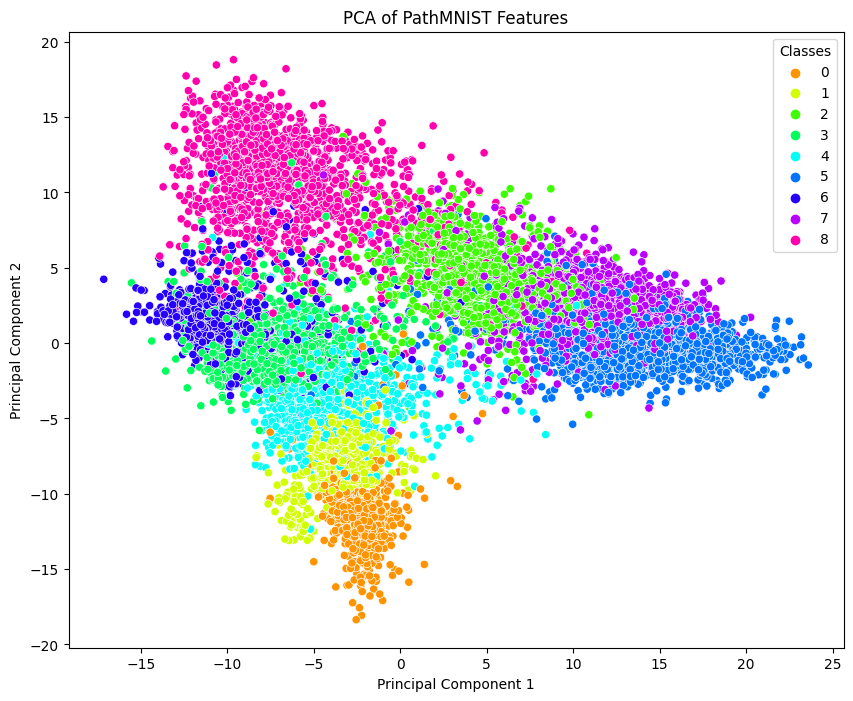

In [61]:
model = SimCLR(base_model='resnet18', out_dim=128).cuda()

# Load the saved model parameters
model.load_state_dict(torch.load('simclr_model.pth'))
model.eval()  # Set the model to evaluation mode


# Extract 1% of training data for fine-tuning
num_samples = len(train_dataset)
indices = list(range(num_samples))
np.random.shuffle(indices)
fine_tune_size = int(num_samples )
fine_tune_indices = indices[:fine_tune_size]

fine_tune_sampler = torch.utils.data.SubsetRandomSampler(fine_tune_indices)
fine_tune_loader = DataLoader(dataset=train_dataset, batch_size=256, sampler=fine_tune_sampler)

# Define a simple classifier for fine-tuning
class FineTuneModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = base_model.encoder
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        h = self.encoder(x).squeeze()
        logits = self.classifier(h)
        return logits
# Convert numpy array to list for getting unique labels
num_classes = 9  #len(set(train_dataset.labels.tolist()))
fine_tune_model = FineTuneModel(model, num_classes).cuda()

# Define the loss function and optimizer for fine-tuning
criterion_fine_tune = nn.CrossEntropyLoss()
optimizer_fine_tune = optim.Adam(fine_tune_model.parameters(), lr=1e-4, weight_decay=1e-6)
# Fine-tuning loop
def fine_tune(model, fine_tune_loader, criterion, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(fine_tune_loader):
        data, target = data.cuda(), target.squeeze().long().cuda()  # Ensure target is 1D
        optimizer.zero_grad()

        # Forward pass
        logits = model(data)
        loss = criterion(logits, target)

        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if batch_idx % 10 == 0:
            print(f'Fine-tune Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}')
    return total_loss / len(fine_tune_loader)

# Fine-tune the model
fine_tune_epochs = 50
for epoch in range(fine_tune_epochs):
    fine_tune_loss = fine_tune(fine_tune_model, fine_tune_loader, criterion_fine_tune, optimizer_fine_tune, epoch)
    print(f'Fine-tune Epoch {epoch}, Train Loss: {fine_tune_loss}')

def save_features(model, data_loader, filename):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.cuda()
            h = model(data)  # Only get the output from the classifier
            features.append(h.cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    np.savez(filename, features=features, labels=labels)

# Save features from the fine-tuned model for evaluation
save_features(fine_tune_model, val_loader, 'pathmnist_features_fine_tuned.npz')

# Load features
data_fine_tuned = np.load('pathmnist_features_fine_tuned.npz')
features_fine_tuned = data_fine_tuned['features']
labels_fine_tuned = data_fine_tuned['labels']

# Split data into training and testing sets
X_train_fine_tuned, X_val_fine_tuned, y_train_fine_tuned, y_val_fine_tuned = train_test_split(features_fine_tuned, labels_fine_tuned, test_size=0.2, random_state=42)

# Standardize the features
scaler_fine_tuned = StandardScaler()
X_train_fine_tuned = scaler_fine_tuned.fit_transform(X_train_fine_tuned)
X_val_fine_tuned = scaler_fine_tuned.transform(X_val_fine_tuned)

# Train logistic regression classifier
classifier_fine_tuned = LogisticRegression(max_iter=1000, random_state=42)
classifier_fine_tuned.fit(X_train_fine_tuned, y_train_fine_tuned)

# Predict on validation set
y_pred_fine_tuned = classifier_fine_tuned.predict(X_val_fine_tuned)

# Calculate accuracy
accuracy_fine_tuned = accuracy_score(y_val_fine_tuned, y_pred_fine_tuned)
print(f'Fine-tuned Validation Accuracy: {accuracy_fine_tuned:.4f}')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

# Load features
data = np.load('pathmnist_features_fine_tuned.npz')
features = data['features']
labels = data['labels']

# Perform PCA to reduce dimensions to 2
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# Ensure labels are 1D
labels = labels.squeeze()

# Create a DataFrame with the PCA results and labels
df = pd.DataFrame({
    'PC1': features_2d[:, 0],
    'PC2': features_2d[:, 1],
    'Label': labels
})

# Visualize the 2D features
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(labels)))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Label', legend='full', palette=palette)
plt.title('PCA of PathMNIST Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Classes')
plt.show()
